In [81]:
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import xarray as xr
import rioxarray as rxr
from pathlib import Path
from scipy.ndimage import generic_filter

In [33]:
# paths
PATH_GLOFAS4 = Path('Z:/nahaUsers/casadje/GloFASv4')
PATH_OUT = Path('E:/casadje/Documents/BAMS_SoCin2024/GIS')

# load upstream area map
uparea = rxr.open_rasterio(PATH_GLOFAS4 / 'static_maps' / 'upArea_repaired.nc').squeeze(dim='band')
uparea = uparea.where(uparea >= 0, np.nan)
uparea /= 1e6 # km2

# load local drainage direction map
ldd = rxr.open_rasterio(PATH_GLOFAS4 / 'static_maps' / 'ldd_repaired.nc').squeeze(dim='band')
ldd = ldd.where(ldd <= 16, np.nan)

# mask of upstream area 10,000 km2
mask_area = uparea >= 1e4
# mask of sinks
mask_ldd = ldd == 5

In [60]:
def has_non_nan_neighbors(window):
    """
    Check if at least one neighboring pixel in the 3x3 window is not NaN.
    The central pixel is included in the check.
    """
    return np.any(~np.isnan(window))

# Apply the function to create the neighbor mask
neighbor_mask = generic_filter(
    uparea.values,  # Input array
    has_non_nan_neighbors,  # Function to apply
    size=3,  # 3x3 neighborhood
    mode='constant',  # Boundary mode
    cval=np.nan  # Fill boundary with NaN
)

In [82]:
# from scipy.signal import convolve2d

# kernel = np.ones((3, 3))

# convolved = convolve2d(uparea.values, kernel, mode='same', fillvalue=np.nan)

# coastal_mask = np.isnan(convolved) & ~np.isnan(uparea.values)

# coastal_mask = xr.DataArray(coastal_mask, dims=uparea.dims, coords=uparea.coords)

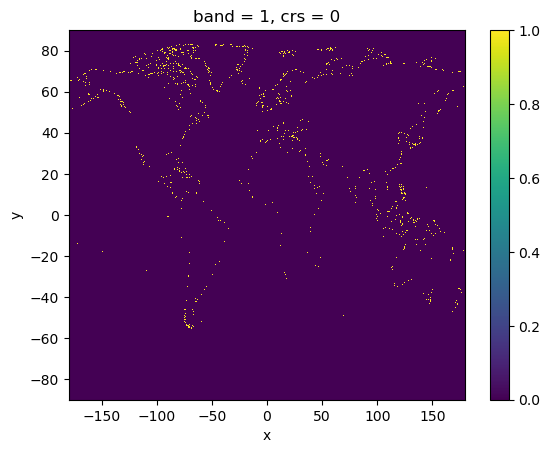

In [83]:
coastal_mask_da.plot();

In [79]:
type(uparea)

xarray.core.dataarray.DataArray

In [72]:
import matplotlib.pyplot as plt

In [76]:
np.max(coastal_mask)

True

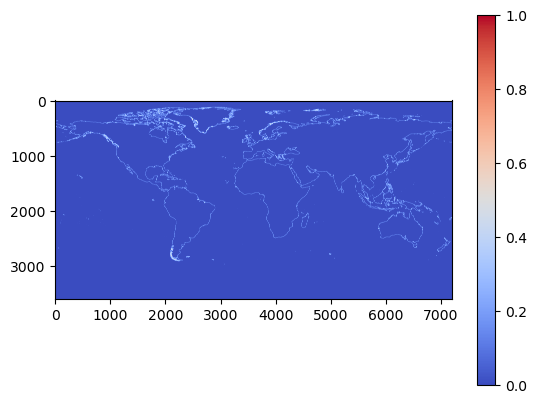

In [75]:
im = plt.imshow(coastal_mask, cmap='coolwarm')
plt.colorbar(im);

In [62]:
neighbor_mask.shape

(3600, 7200)

In [84]:
# filter pixels
outlets = uparea.where(mask_area & mask_ldd & coastal_mask_da, np.nan)

In [85]:
outlets_df = outlets.to_dataframe().reset_index()
outlets_df = outlets_df[outlets_df.Band1.notnull()]
outlets_df.head()

,y,x,band,crs,Band1
1140229,82.075,-48.525,1,0,13985.166016
1205096,81.625,-45.175,1,0,34817.500000
1205348,81.625,-32.575,1,0,10572.432617
1276771,81.125,-61.425,1,0,58433.992188
1284748,81.075,-22.575,1,0,10121.638672


In [86]:
points = [Point(x, y) for x, y in zip(outlets_df.x, outlets_df.y)]
gdf = gpd.GeoDataFrame(outlets_df, geometry=points, crs='epsg:4326')

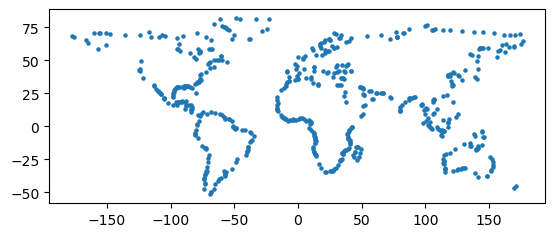

In [87]:
gdf.plot(markersize=5);

In [88]:
gdf.to_file(PATH_OUT / 'outlets2.shp')

In [36]:
# Step 1: Extract non-null cells
non_null_cells = np.where(~np.isnan(outlets.values))

In [37]:
outlets.rio.transform()

Affine(0.049999999999999996, 0.0, -180.0,
       0.0, -0.049999999999999996, 90.0)

In [35]:
# Step 2: Convert raster indices to coordinates
x_coords, y_coords = outlets.rio.transform_xy(non_null_cells[1], non_null_cells[0])  # X, Y from raster indices
values = outlets.values[non_null_cells]  # Extract corresponding values

# Step 3: Create Points and GeoDataFrame
points = [Point(x, y) for x, y in zip(x_coords, y_coords)]
gdf = gpd.GeoDataFrame({"value": values}, geometry=points, crs=outlets.rio.crs)

AttributeError: 'RasterArray' object has no attribute 'transform_xy'

In [30]:
outlets.notnull().sum()

<xarray.DataArray 'Band1' ()>
array(1244)
Coordinates:
    band     int32 1
    crs      int32 0

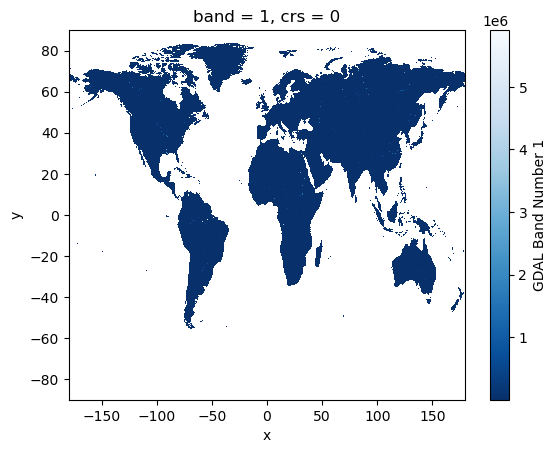

In [23]:
uparea.plot(cmap='Blues_r');

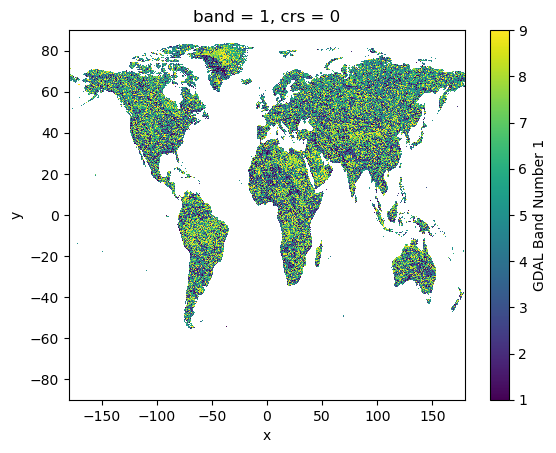

In [21]:
ldd.plot();